In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [3]:
df = pd.read_csv('gun-violence-data_01-2013_03-2018.csv')
df

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239672,1083142,2018-03-31,Louisiana,Rayne,North Riceland Road and Highway 90,0,0,http://www.gunviolencearchive.org/incident/108...,http://www.klfy.com/news/local/rayne-woman-cha...,False,...,0::25,0::Adult 18+,0::Female,0::Jhkeya Tezeno,NaN,"0::Unharmed, Arrested",0::Subject-Suspect,http://www.klfy.com/news/local/rayne-woman-cha...,NaN,NaN
239673,1083139,2018-03-31,Louisiana,Natchitoches,247 Keyser Ave,1,0,http://www.gunviolencearchive.org/incident/108...,http://www.ksla.com/story/37854648/man-wanted-...,False,...,1::21,0::Adult 18+||1::Adult 18+,0::Male||1::Male,0::Jamal Haskett||1::Jaquarious Tyjuan Ardison,NaN,"0::Killed||1::Unharmed, Arrested",0::Victim||1::Subject-Suspect,http://www.ksla.com/story/37854648/man-wanted-...,23.0,31.0
239674,1083151,2018-03-31,Louisiana,Gretna,1300 block of Cook Street,0,1,http://www.gunviolencearchive.org/incident/108...,http://www.nola.com/crime/index.ssf/2018/04/sh...,False,...,0::21,0::Adult 18+,0::Male,NaN,NaN,0::Injured,0::Victim,http://www.nola.com/crime/index.ssf/2018/04/sh...,85.0,7.0
239675,1082514,2018-03-31,Texas,Houston,12630 Ashford Point Dr,1,0,http://www.gunviolencearchive.org/incident/108...,https://www.ch

In [4]:
df.isnull().sum()

incident_id                         0
date                                0
state                               0
city_or_county                      0
address                         16497
n_killed                            0
n_injured                           0
incident_url                        0
source_url                        468
incident_url_fields_missing         0
congressional_district          11944
gun_stolen                      99498
gun_type                        99451
incident_characteristics          326
latitude                         7923
location_description           197588
longitude                        7923
n_guns_involved                 99451
notes                           81017
participant_age                 92298
participant_age_group           42119
participant_gender              36362
participant_name               122253
participant_relationship       223903
participant_status              27626
participant_type                24863
sources     

In [5]:
cat_features = ['participant_age_group', 'participant_gender', 'gun_type', 'gun_stolen', 'participant_relationship']

def most_frequent_category(cat_string):
    if pd.isna(cat_string):
        return 'Unknown'
    parts = cat_string.split('||')
    categories = [p.split('::')[1] if '::' in p else p for p in parts]
    return Counter(categories).most_common(1)[0][0]

df_processed = df.copy()

for col in cat_features:
    new_col = col + '_main'
    df_processed[new_col] = df_processed[col].apply(most_frequent_category)

new_cat_features = [col + '_main' for col in cat_features]
num_features = ['n_killed', 'n_injured']

In [6]:
df_processed

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_status,participant_type,sources,state_house_district,state_senate_district,participant_age_group_main,participant_gender_main,gun_type_main,gun_stolen_main,participant_relationship_main
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN,Adult 18+,Male,Unknown,Unknown,Unknown
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0,Adult 18+,Male,Unknown,Unknown,Unknown
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0,Adult 18+,Male,Unknown,Unknown,Unknown
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0,Adult 18+,Male,Unknown,Unknown,Unknown
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0,Adult 18+,Female,Handgun,Unknown,Family
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239672,1083142,2018-03-31,Louisiana,Rayne,North Riceland Road and Highway 90,0,0,http://www.gunviolencearchive.org/incident/108...,http://www.klfy.com/news/local/rayne-woman-cha...,False,...,"0::Unharmed, Arrested",0::Subject-Suspect,http://www.klfy.com/news/local/rayne-woman-cha...,NaN,NaN,Adult 18+,Female,Unknown,Unknown,Unknown
239673,1083139,2018-03-31,Louisiana,Natchitoches,247 Keyser Ave,1,0,http://www.gunviolencearchive.org/incident/108...,http://www.ksla.com/story/37854648/man-wanted-...,False,...,"0::Killed||1::Unharmed, Arrested",0::Victim||1::Subject-Suspect,http://www.ksla.com/story/37854648/man-wanted-...,23.0,31.0,Adult 18+,Male,Unknown,Unknown,Unknown
239674,1083151,2018-03-31,Louisiana,Gretna,1300 block of Cook Street,0,1,http://www.gunviolencearchive.org/incident/108...,http://www.nola.com/crime/index.ssf/2018/04/sh...,False,...,0::Injured,0::Victim,http://www.nola.com/crime/index.ssf/2018/04/sh...,85.0,7.0,Adult 18+,Male,Unknown,Unknown,Unknown
239675,1082514,2018-03-31,Texas,Houston,12630 Ashford Point Dr,1,0,http://www.gunviolencearchive.org/incident/108...,https://www.chron.com/news/houston-texas/houst...,False,...,0::Killed,0::Victim,http://www.khou.com/article/news/hpd-investiga...,149.0,17.0,Adult 18+,Male,Unknown,Unknown,Unknown


In [7]:
preprocessor = ColumnTransformer([
    ("cat", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), new_cat_features),
    ("num", StandardScaler(), num_features)
])

X = preprocessor.fit_transform(df_processed)

In [8]:
X.shape

(239677, 7)

In [9]:
X_sample = X[:10000]

In [10]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(X_sample)
print("KMeans Silhouette Score:", silhouette_score(X_sample, kmeans_labels))

KMeans Silhouette Score: 0.8790631853245698


In [11]:
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_sample)
print("DBSCAN Silhouette Score:", silhouette_score(X_sample, dbscan_labels, metric='euclidean'))

DBSCAN Silhouette Score: 0.428985314642191


In [12]:
agg = AgglomerativeClustering(n_clusters=5) 
agg_labels = agg.fit_predict(X_sample)
score = silhouette_score(X_sample, agg_labels)
print(f"Agglomerative Silhouette Score: {score:.4f}")

Agglomerative Silhouette Score: 0.8695


Лучшая модель - K-Means, это объясняется высоким значением silhouette_score(0.88)

### k-means features

In [13]:
rf = RandomForestClassifier()
rf.fit(X_sample.toarray() if hasattr(X_sample, 'toarray') else X_sample, kmeans_labels)
importances = rf.feature_importances_
feature_names = preprocessor.get_feature_names_out()
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feat_imp.head(10))

cat__participant_gender_main          0.564388
cat__participant_age_group_main       0.400369
cat__gun_type_main                    0.013817
cat__gun_stolen_main                  0.013534
num__n_killed                         0.003178
num__n_injured                        0.002546
cat__participant_relationship_main    0.002169
dtype: float64


### dbscan features

In [14]:
mask = dbscan_labels != -1
X_filtered = X_sample[mask]
y_filtered = dbscan_labels[mask]

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_filtered.toarray() if hasattr(X_filtered, 'toarray') else X_filtered, y_filtered)

importances = rf.feature_importances_
feature_names = preprocessor.get_feature_names_out()
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

print(feat_imp.head(10))

cat__participant_gender_main          0.362798
num__n_killed                         0.358090
cat__participant_age_group_main       0.224191
cat__gun_type_main                    0.020976
num__n_injured                        0.018309
cat__gun_stolen_main                  0.008113
cat__participant_relationship_main    0.007522
dtype: float64


### AgglomerativeClustering features

In [15]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_sample.toarray() if hasattr(X_sample, 'toarray') else X_sample, agg_labels)

importances = rf.feature_importances_
feature_names = preprocessor.get_feature_names_out()
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

print(feat_imp.head(10))

cat__participant_gender_main          0.486001
cat__participant_age_group_main       0.468389
cat__gun_stolen_main                  0.018387
cat__gun_type_main                    0.014255
num__n_injured                        0.006465
num__n_killed                         0.003911
cat__participant_relationship_main    0.002591
dtype: float64


### Anomalies

In [16]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)
anomaly_scores = iso_forest.fit_predict(X)

anomaly_mask = anomaly_scores == -1
anomalies = df_processed[anomaly_mask]

print(f"Найдено аномальных инцидентов: {anomalies.shape[0]}")
print("\nПримеры аномалий:")
display(anomalies[['date', 'state', 'city_or_county', 'n_killed', 'n_injured', 'gun_type_main', 'participant_age_group_main', 'participant_gender_main', 'participant_relationship_main']].head(10))

Найдено аномальных инцидентов: 4784

Примеры аномалий:


,date,state,city_or_county,n_killed,n_injured,gun_type_main,participant_age_group_main,participant_gender_main,participant_relationship_main
4,2013-01-07,North Carolina,Greensboro,2,2,Handgun,Adult 18+,Female,Family
6,2013-01-19,New Mexico,Albuquerque,5,0,22 LR,Child 0-11,Male,Family
16,2013-02-03,California,Yuba (county),1,3,9mm,Adult 18+,Male,Drive by - Random victims
20,2013-02-11,Delaware,Wilmington,3,2,45 Auto,Adult 18+,Male,Unknown
22,2013-02-19,California,Orange (county),4,3,12 gauge,Adult 18+,Male,Unknown
36,2013-03-13,New York,Mohawk,6,2,Shotgun,Adult 18+,Male,Aquaintance
44,2013-03-30,California,Merced (county),3,2,Unknown,Adult 18+,Male,Gang vs Gang
51,2013-04-14,Arizona,Phoenix,2,4,Unknown,Adult 18+,Male,Unknown
54,2013-04-21,Washington,Federal Way,5,0,40 SW,Adult 18+,Male,Unknown
83,2013-05-23,Tennessee,Bean Station,2,2,Unknown,Adult 18+,Male,Armed Robbery


In [17]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_sample)

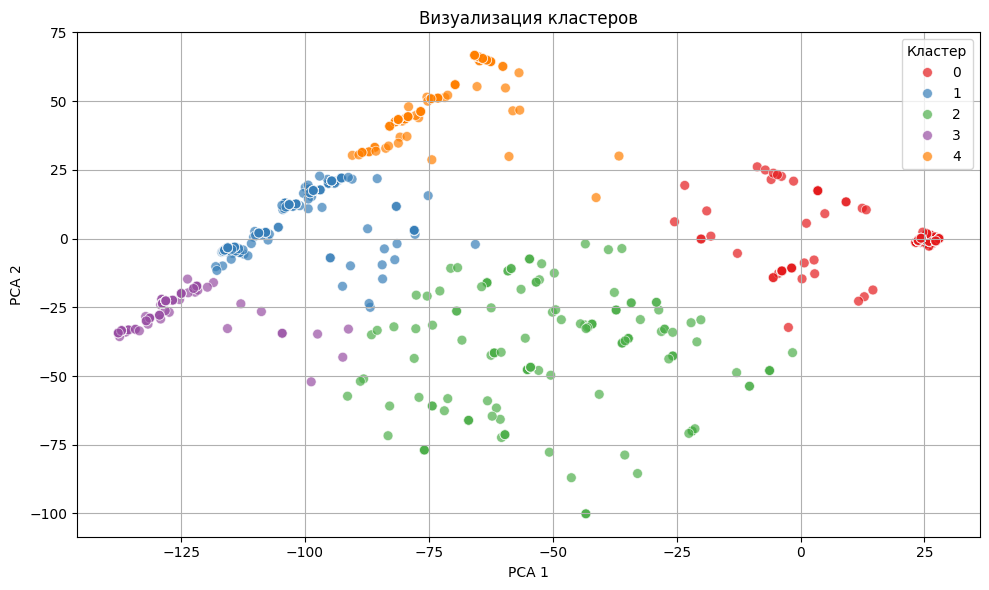

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='Set1', s=50, alpha=0.7)
plt.title('Визуализация кластеров')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Кластер')
plt.grid(True)
plt.tight_layout()
plt.show()